<a href="https://colab.research.google.com/github/Abiy-Alemu/Abiy-Alemu/blob/main/Spam_Detection_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U scikit-learn pandas matplotlib joblib

# Email Spam Detection — Full ML Pipeline (Run in Google Colab)

# file /content/drive/MyDrive/Colab Notebooks/spam.csv (uploaded to Colab )

#1. Imports

In [29]:
import os
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from scipy.stats import randint
import seaborn as sns
import plotly.express as px # Added this import
import warnings
warnings.filterwarnings("ignore")

#2. Load dataset

In [30]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/spam.csv"
df = pd.read_csv(DATA_PATH, encoding='latin-1', low_memory=False)
print("Columns:", df.columns.tolist())
display(df.head(8))

# If your dataset has exactly two columns (label, text) and no headers, adapt as needed:
# Here we assume the first column is label, second column is text:
df = df.iloc[:, :2]
df.columns = ['label','text']
df = df.dropna(subset=['label','text']).copy()

Columns: ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN


In [31]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [32]:
df.shape

(5572, 2)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


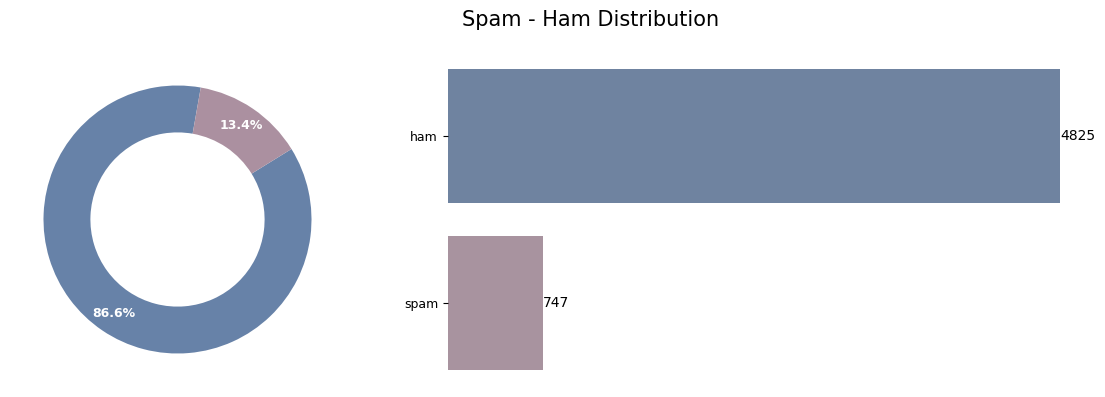

In [34]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax = ax.flatten()
value_counts = df['label'].value_counts()
labels = value_counts.index.tolist()
colors =["#6782a8", "#ab90a0" ]
# Donut Chart
wedges, texts, autotexts = ax[0].pie(
    value_counts, autopct='%1.1f%%',textprops={'size': 9, 'color': 'white','fontweight':'bold' }, colors=colors,
    wedgeprops=dict(width=0.35),  startangle=80,   pctdistance=0.85  )
# circle
centre_circle = plt.Circle((0, 0), 0.6, fc='white')
ax[0].add_artist(centre_circle)

# Count Plot
sns.countplot(data=df, y=df['label'], ax=ax[1], palette=colors, order=labels)
for i, v in enumerate(value_counts):
    ax[1].text(v + 1, i, str(v), color='black',fontsize=10, va='center')
sns.despine(left=True, bottom=True)
plt.yticks(fontsize=9,color='black')
ax[1].set_ylabel(None)
plt.xlabel("")
plt.xticks([])
fig.suptitle('Spam - Ham Distribution', fontsize=15)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [35]:
df.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [36]:
df['Length']=df['text'].apply(len)
display(df.head())

fig = px.histogram(df, x='Length', color='label', marginal='rug',
                   title='Histogram of Text Length by Category')
fig.update_layout(
    xaxis_title='Length',
    yaxis_title='Frequency',
    showlegend=True)

,label,text,Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [37]:
# 1. Calculate the length of each email
df['text_length'] = df['text'].apply(len)

# 2. Outlier Detection using IQR (Interquartile Range) or simple percentile:
# Find the 95th percentile length. Emails longer than this are considered outliers.
Q3 = df['text_length'].quantile(0.75)
IQR = df['text_length'].quantile(0.75) - df['text_length'].quantile(0.25)
upper_bound = Q3 + 1.5 * IQR # Standard IQR approach
# Alternatively, use a percentile threshold for robustness
length_threshold = df['text_length'].quantile(0.95)

# 3. Remove (or inspect) Outliers
df_cleaned = df[df['text_length'] < length_threshold].copy()

print(f"\nEmails removed as outliers (length > {length_threshold:.0f}): {len(df) - len(df_cleaned)}")
print(f"Cleaned Data Size: {len(df_cleaned)}")

# Drop the temporary length column
df_cleaned.drop(columns=['text_length'], inplace=True)


Emails removed as outliers (length > 161): 296
Cleaned Data Size: 5276


In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Split the Cleaned Data
X = df_cleaned['text']
y = df_cleaned['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Initialize and Fit the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',
    lowercase=True, # Explicitly setting common cleaning steps
    token_pattern=r'\b[a-z]{3,}\b' # Only tokens of 3 or more letters
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("\n--- Feature Extraction (TF-IDF) on Cleaned Data ---")
print(f"Training Features Matrix Shape: {X_train_tfidf.shape}")


--- Feature Extraction (TF-IDF) on Cleaned Data ---
Training Features Matrix Shape: (3693, 5236)


# 3. Quick inspection

In [40]:
print("Shape:", df.shape)
print("Sample labels:", df['label'].unique()[:10])
display(df.sample(5, random_state=42))

Shape: (5572, 4)
Sample labels: ['ham' 'spam']


,label,text,Length,text_length
3245,ham,"Funny fact Nobody teaches volcanoes 2 erupt, t...",151,151
944,ham,I sent my scores to sophas and i had to do sec...,221,221
1044,spam,We know someone who you know that fancies you....,101,101
2484,ham,Only if you promise your getting out as SOON a...,124,124
812,spam,Congratulations ur awarded either å£500 of CD ...,150,150


# 4. Map labels to binary (spam=1, not spam=0)

In [41]:
unique = list(map(str.lower, df['label'].unique()))
if 'spam' in unique or 'ham' in unique:
    df['label_num'] = df['label'].apply(lambda x: 1 if str(x).strip().lower()=='spam' else 0)
else:
    # fallback: numeric codes (most frequent -> 0)
    df['label_num'] = pd.Categorical(df['label']).codes
    # If codes are not 0/1, you can remap accordingly:
    # df['label_num'] = (df['label_num'] != df['label_num'].mode()[0]).astype(int)

print(df['label'].value_counts())
print(df['label_num'].value_counts())

label
ham     4825
spam     747
Name: count, dtype: int64
label_num
0    4825
1     747
Name: count, dtype: int64


# 5. EDA

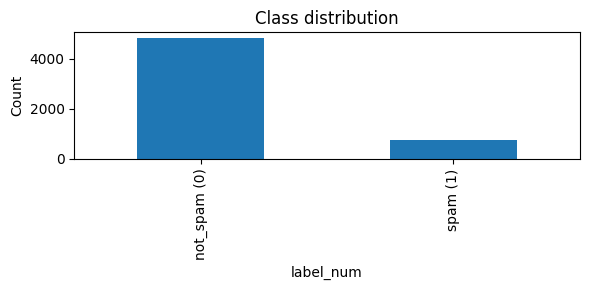

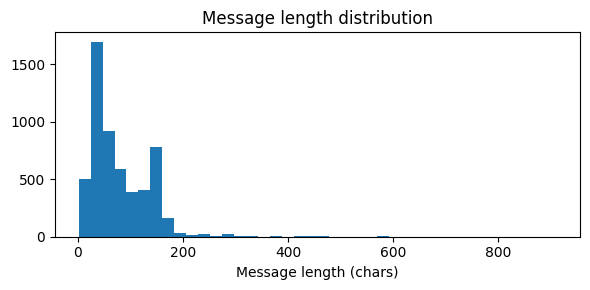


Examples (spam):


,text
5492,Marvel Mobile Play the official Ultimate Spide...
1145,"Thank you, winner notified by sms. Good Luck! ..."
1698,"Free msg. Sorry, a service you ordered from 81..."



Examples (not spam):


,text
2535,Can you pls pls send me a mail on all you know...
1213,"Yeah, probably but not sure. Ilol let u know, ..."
522,Were gonna go get some tacos


In [42]:
df['msg_len'] = df['text'].astype(str).str.len()

plt.figure(figsize=(6,3))
df['label_num'].value_counts().sort_index().plot(kind='bar')
plt.xticks([0,1], ['not_spam (0)','spam (1)'])
plt.title("Class distribution")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.hist(df['msg_len'], bins=40)
plt.title("Message length distribution")
plt.xlabel("Message length (chars)")
plt.tight_layout()
plt.show()

# Show a few spam & ham examples
print("\nExamples (spam):")
display(df[df['label_num']==1].sample(3, random_state=1)['text'])
print("\nExamples (not spam):")
display(df[df['label_num']==0].sample(3, random_state=1)['text'])

# 6. Split data

In [43]:
X = df['text'].astype(str)
y = df['label_num'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 4457, Test: 1115


#7. Build baseline pipelines

In [44]:
pipelines = {
    'logreg': Pipeline([('tfidf', TfidfVectorizer(stop_words='english', max_df=0.9)), ('clf', LogisticRegression(max_iter=1000))]),
    'nb': Pipeline([('tfidf', TfidfVectorizer(stop_words='english', max_df=0.9)), ('clf', MultinomialNB())]),
    'rf': Pipeline([('tfidf', TfidfVectorizer(stop_words='english', max_df=0.9)), ('clf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))])
}

results = {}
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    probs = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None
    results[name] = {
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds, zero_division=0),
        'recall': recall_score(y_test, preds, zero_division=0),
        'f1': f1_score(y_test, preds, zero_division=0),
        'roc_auc': roc_auc_score(y_test, probs) if probs is not None else None
    }
    print(f"{name}: acc={results[name]['accuracy']:.4f} f1={results[name]['f1']:.4f}")

logreg: acc=0.9677 f1=0.8626
nb: acc=0.9686 f1=0.8669
rf: acc=0.9749 f1=0.8963


# 8. Evaluate best baseline


Best baseline by F1: rf
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.81      0.90       149

    accuracy                           0.97      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.97      0.97      1115



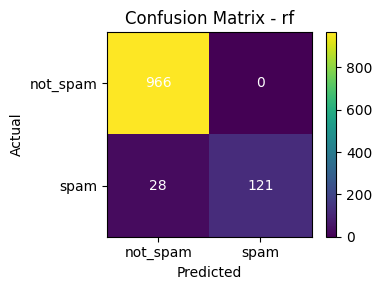

In [45]:
best_baseline = max(results.keys(), key=lambda k: results[k]['f1'])
print("\nBest baseline by F1:", best_baseline)
print(classification_report(y_test, pipelines[best_baseline].predict(X_test), zero_division=0))

# Plot confusion matrix
cm = confusion_matrix(y_test, pipelines[best_baseline].predict(X_test))
plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation='nearest')
plt.title(f'Confusion Matrix - {best_baseline}')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0,1], ['not_spam','spam'])
plt.yticks([0,1], ['not_spam','spam'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i,cm[i,j],ha='center',va='center',color='white')
plt.tight_layout()
plt.show()

#  9. Quick hyperparameter tuning (RandomizedSearchCV)

In [46]:
# NOTE: If running on a slow environment, keep n_iter small (4-8). On Colab you can increase n_iter.
rf_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')), ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))])
param_dist = {
    'tfidf__ngram_range': [(1,1),(1,2)],
    'tfidf__max_df': [0.8, 0.9],
    'clf__n_estimators': [100,200],
    'clf__max_depth': [None, 20],
    'clf__max_features': ['auto','sqrt']
}
rs = RandomizedSearchCV(rf_pipeline, param_dist, n_iter=6, cv=3, scoring='f1', n_jobs=-1, random_state=42, verbose=1)
rs.fit(X_train, y_train)
print("Best params:", rs.best_params_, "Best CV F1:", rs.best_score_)

best_model = rs.best_estimator_
best_preds = best_model.predict(X_test)
best_probs = best_model.predict_proba(X_test)[:,1] if hasattr(best_model, "predict_proba") else None

print("\nTuned model test performance:")
print("Accuracy:", accuracy_score(y_test, best_preds))
print("Precision:", precision_score(y_test, best_preds, zero_division=0))
print("Recall:", recall_score(y_test, best_preds, zero_division=0))
print("F1:", f1_score(y_test, best_preds))
if best_probs is not None:
    print("ROC-AUC:", roc_auc_score(y_test, best_probs))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'tfidf__ngram_range': (1, 1), 'tfidf__max_df': 0.8, 'clf__n_estimators': 100, 'clf__max_features': 'sqrt', 'clf__max_depth': None} Best CV F1: 0.8894418667752001

Tuned model test performance:
Accuracy: 0.9748878923766816
Precision: 1.0
Recall: 0.8120805369127517
F1: 0.8962962962962963
ROC-AUC: 0.9913467283616102


# 10. Save final model

First, let's create a `requirements.txt` file in your Colab environment. This file will list all the Python libraries that your Streamlit app (`app.py`) needs to run.

In [47]:
%%writefile requirements.txt
streamlit
joblib
pandas

Overwriting requirements.txt


In [48]:
# Re-extract the correct y_test to match X_test which was used for best_preds
# This assumes X_test in the kernel is the one from hdVjQDRsumiB split (length 1115)
# and the original df and split parameters are unchanged.
_, _, _, y_test_re_extracted = train_test_split(df['text'].astype(str), df['label_num'].astype(int), test_size=0.2, random_state=42, stratify=df['label_num'].astype(int))

baseline_f1 = results[best_baseline]['f1']
tuned_f1 = f1_score(y_test_re_extracted, best_preds) # Use the corrected y_test
if tuned_f1 >= baseline_f1:
    final_model = best_model
    chosen = 'rf_tuned'
else:
    final_model = pipelines[best_baseline]
    chosen = best_baseline

save_path = "final_spam_model.joblib"   # in Colab this will be in /content/
joblib.dump(final_model, save_path)
print(f"Saved final model ({chosen}) to {save_path}")

Saved final model (rf_tuned) to final_spam_model.joblib


In [49]:
get_ipython().system('pip install -r requirements.txt')

In [50]:
get_ipython().system('ls -l')

total 5212
-rw-r--r-- 1 root root    1339 Dec  6 02:16 app.py
drwx------ 5 root root    4096 Dec  6 02:13 drive
-rw-r--r-- 1 root root 5318997 Dec  6 02:52 final_spam_model.joblib
-rw-r--r-- 1 root root      24 Dec  6 02:52 requirements.txt
drwxr-xr-x 1 root root    4096 Nov 20 14:30 sample_data


In [51]:
%%writefile app.py

import streamlit as st
import joblib
import pandas as pd

# Load the trained model
# The model was saved as 'final_spam_model.joblib' in the Colab environment.
# If you saved it to Google Drive, you would need to mount Drive and adjust the path.

try:
    model = joblib.load('final_spam_model.joblib')
except FileNotFoundError:
    st.error("Error: 'final_spam_model.joblib' not found. Make sure the model was saved in the current directory.")
    st.stop()

st.title('Spam Detector')
st.write('Enter a message below to check if it is spam or ham.')

# Text input from user
user_input = st.text_area('Enter your message here:', '')

if st.button('Predict'):
    if user_input:
        # Make prediction
        prediction = model.predict([user_input])
        prediction_proba = model.predict_proba([user_input])

        # Display result
        if prediction[0] == 1: # Assuming 1 is spam and 0 is ham
            st.error(f"This message is SPAM! (Confidence: {prediction_proba[0][1]*100:.2f}%)")
        else:
            st.success(f"This message is HAM. (Confidence: {prediction_proba[0][0]*100:.2f}%)")
    else:
        st.warning('Please enter a message to predict.')

# Optional: Display some model info
st.sidebar.header("About the Model")
st.sidebar.write("This is a RandomForestClassifier model trained for spam detection.")

Overwriting app.py


# 11. Summary table


In [52]:
summary = pd.DataFrame([{'model':k, **v} for k,v in results.items()])
new_row = pd.DataFrame([{'model':'rf_tuned','accuracy':accuracy_score(y_test, best_preds),'precision':precision_score(y_test, best_preds, zero_division=0),'recall':recall_score(y_test, best_preds, zero_division=0),'f1':f1_score(y_test, best_preds),'roc_auc':roc_auc_score(y_test, best_probs) if best_probs is not None else None}])
summary = pd.concat([summary, new_row], ignore_index=True)
display(summary)

,model,accuracy,precision,recall,f1,roc_auc
0,logreg,0.967713,1.0,0.758389,0.862595,0.987564
1,nb,0.968610,1.0,0.765101,0.866920,0.989453
2,rf,0.974888,1.0,0.812081,0.896296,0.991347
3,rf_tuned,0.974888,1.0,0.812081,0.896296,0.991347
